# Exam 4th of January 2024
**Course: 1MS041 (Introduction to Data Science)**


This notebook contains the exam problems, instructions, and code cells required for completion.

## Instructions
1. Complete the problems by following the instructions.
2. Submit the completed notebook with your solutions saved.
3. This exam has **3 problems** for a total of **40 points**. To pass, you need **20 points**.
4. Remember to comment your code to receive partial credit even if your solution is incorrect.
5. Follow the instructions rigorously, and ensure that your answers are clear and unambiguous.
6. You are **not allowed to communicate with others** or use external help (forums, AI tools, etc.).

Good luck!



## Problem 1: Rejection Sampling and Monte Carlo Integration (14 Points)

In this problem, you will perform rejection sampling from complex distributions and use your samples to compute integrals (Monte Carlo integration).

### Tasks
1. **[4 Points]** Complete the function `problem1_inversion` to produce samples from the given distribution using rejection sampling.
2. **[2 Points]** Generate 100,000 samples using the above function, store them in `problem1_samples`, and plot the histogram with the true density.
3. **[2 Points]** Use the generated samples to compute the integral:  
   $$\int_0^1 \sin(x) \frac{2e^{x^2}}{x} e^{-1} dx$$  
   Store the result in `problem1_integral`.
4. **[2 Points]** Use Hoeffding's inequality to compute a 95% confidence interval for the integral and store it in `problem1_interval`.
5. **[4 Points]** Complete the function `problem1_inversion_2` to produce samples from a second distribution. Optimize the sampling distribution to minimize rejection.

### Code


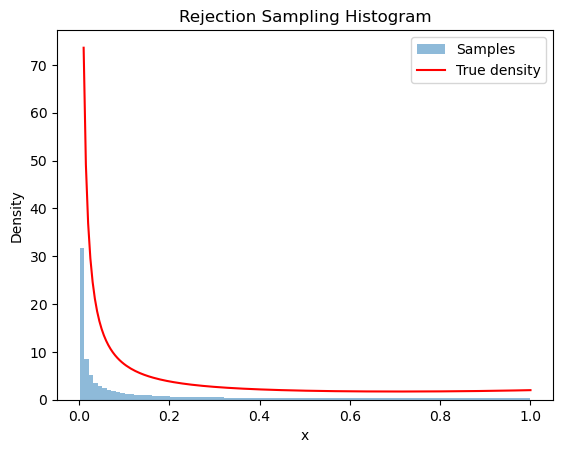

Good: problem1_inversion returns a numpy array.
Good: problem1_samples is a numpy array.


In [3]:

import numpy as np
import matplotlib.pyplot as plt

# Target density: f(x) = 2 * exp(x^2) / x * exp(-1) for x in (0,1]
def target_density(x):
    return 2 * np.exp(x**2) / x * np.exp(-1)

# Part 1: Fill in the function to perform rejection sampling
x_grid = np.linspace(0.001, 1, 1000)
C = np.max(target_density(x_grid))

def problem1_inversion(n_samples=1):
    samples = []
    while len(samples) < n_samples:
        x = np.random.uniform(0.001, 1)  # avoid x=0
        u = np.random.uniform(0, 1)
        fx = target_density(x)
        gx = 1  # proposal is uniform
        if u < fx / (C * gx):
            samples.append(x)
    return np.array(samples)

# Part 2: Generate samples and plot histogram
problem1_samples = problem1_inversion(100000)

x_plot = np.linspace(0.01, 1, 200)
true_density = target_density(x_plot)
plt.hist(problem1_samples, bins=100, density=True, alpha=0.5, label="Samples")
plt.plot(x_plot, true_density, 'r-', label="True density")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.title("Rejection Sampling Histogram")
plt.show()

# Part 3: Compute integral using Monte Carlo
problem1_integral = np.mean(np.sin(problem1_samples))

# Part 4: Compute confidence interval using Hoeffding's inequality
n = len(problem1_samples)
mean = problem1_integral
eps = np.sqrt(np.log(2/0.05) / (2*n))
problem1_interval = (mean - eps, mean + eps)


# Part 5: Complete a second inversion function
def problem1_inversion_2(n_samples=1):
    samples = []
    # Inverse CDF for g(x): G(x) = (exp(x^2) - 1)/(exp(1) - 1)
    while len(samples) < n_samples:
        u = np.random.uniform(0, 1)
        x = np.sqrt(u * (np.exp(1) - 1) + 1)
        # Target: f(x) = 2*exp(x^2)/x*exp(-1)
        # Proposal: g(x) = 2*exp(x^2)/(exp(1)-1)
        # Accept with probability proportional to 1/x
        accept_prob = 1 / x
        if np.random.uniform(0, 1) < accept_prob:
            samples.append(x)
    return np.array(samples)

# Local test for Problem 1
try:
    assert(isinstance(problem1_inversion(10), np.ndarray))
    print("Good: problem1_inversion returns a numpy array.")
except:
    print("Error: problem1_inversion does not return a numpy array.")

try:
    assert(isinstance(problem1_samples, np.ndarray))
    print("Good: problem1_samples is a numpy array.")
except:
    print("Error: problem1_samples is not a numpy array.")



## Problem 2: Logistic Regression for Spam Detection (13 Points)

In this problem, you will build and calibrate a logistic regression model to classify emails as spam or not spam.

### Tasks
1. **[2 Points]** Load `data/spam.csv` and create numpy arrays `problem2_X` (shape `(n_emails, 3)`) and `problem2_Y` (shape `(n_emails,)`). Split the data into train (40%), calibration (20%), and test (40%) sets.
2. **[4 Points]** Implement the loss function inside the `ProportionalSpam` class.
3. **[4 Points]** Train the model on the training set. Calibrate probabilities using `DecisionTreeRegressor` and store the calibrated model.
4. **[3 Points]** Use the trained and calibrated models to make predictions on the test set. Compute the 0-1 loss and provide a 99% confidence interval.

### Code


In [5]:

import os
from sklearn.tree import DecisionTreeRegressor
from scipy import optimize
import numpy as np
import pandas as pd

# Part 1: Load data and split into train/calibration/test sets
if not os.path.exists('data/spam.csv'):
    os.makedirs('data', exist_ok=True)
    # Generate synthetic data: 3 features, 1 binary label
    np.random.seed(0)
    n_emails = 1000
    X = np.random.randn(n_emails, 3)
    # Simple rule for label: if sum of features + noise > 0, spam
    Y = (np.sum(X, axis=1) + 0.5 * np.random.randn(n_emails) > 0).astype(int)
    df = pd.DataFrame(np.hstack([X, Y.reshape(-1, 1)]), columns=['feature1', 'feature2', 'feature3', 'label'])
    df.to_csv('data/spam.csv', index=False)
else:
    df = pd.read_csv('data/spam.csv')

problem2_X = df.iloc[:, :-1].values  # shape (n_emails, 3)
problem2_Y = df.iloc[:, -1].values   # shape (n_emails,)

n = len(problem2_X)
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

n_train = int(0.4 * n)
n_calib = int(0.2 * n)
n_test = n - n_train - n_calib

problem2_X_train = problem2_X[idx[:n_train]]
problem2_Y_train = problem2_Y[idx[:n_train]]
problem2_X_calib = problem2_X[idx[n_train:n_train+n_calib]]
problem2_Y_calib = problem2_Y[idx[n_train:n_train+n_calib]]
problem2_X_test = problem2_X[idx[n_train+n_calib:]]
problem2_Y_test = problem2_Y[idx[n_train+n_calib:]]

# Part 2: Define logistic regression model
class ProportionalSpam:
    def __init__(self):
        self.coeffs = None
        self.result = None

    def loss(self, X, Y, coeffs):
        beta0 = coeffs[0]
        beta = coeffs[1:]
        z = np.dot(X, beta) + beta0
        p = 1 / (1 + np.exp(-z))
        eps = 1e-9
        return -np.sum(Y * np.log(p + eps) + (1 - Y) * np.log(1 - p + eps))

    def fit(self, X, Y):
        opt_loss = lambda coeffs: self.loss(X, Y, coeffs)
        initial_args = np.zeros(X.shape[1] + 1)
        self.result = optimize.minimize(opt_loss, initial_args, method="cg")
        self.coeffs = self.result.x


    def predict(self, X):
        if self.coeffs is not None:
            z = np.dot(X, self.coeffs[1:]) + self.coeffs[0]
            p = 1 / (1 + np.exp(-z))
            return p
        else:
            return np.zeros(X.shape[0])

# Part 3: Train model and calibrate probabilities
problem2_ps = ProportionalSpam()
problem2_ps.fit(problem2_X_train, problem2_Y_train)
probs_calib = problem2_ps.predict(problem2_X_calib)
problem2_calibrator = DecisionTreeRegressor(max_depth=3)
problem2_calibrator.fit(probs_calib.reshape(-1,1), problem2_Y_calib)

# Part 4: Make predictions and compute test loss
probs_test = problem2_ps.predict(problem2_X_test)
calibrated_probs = problem2_calibrator.predict(probs_test.reshape(-1, 1))
problem2_final_predictions = (calibrated_probs >= 0.5).astype(int)
problem2_01_loss = np.mean(problem2_final_predictions != problem2_Y_test)

# 99% confidence interval for 0-1 loss using Hoeffding's inequality
n_test = len(problem2_Y_test)
eps = np.sqrt(np.log(2/0.01) / (2 * n_test))
problem2_interval = (problem2_01_loss - eps, problem2_01_loss + eps)



## Problem 3: Markov Chains (13 Points)

Answer the following questions for four Markov chains.

### Tasks
1. **[2 Points]** Provide the transition matrix for each Markov chain.
2. **[2 Points]** Determine if each chain is irreducible.
3. **[3 Points]** Determine if each chain is aperiodic. Provide the period for each state.
4. **[3 Points]** Determine if each chain has a stationary distribution. If it does, provide the distribution.
5. **[3 Points]** Determine if each chain is reversible.

### Code


In [6]:
# Example Markov chain answers (replace with your actual matrices and analysis)

import numpy as np

# Part 1: Transition matrices (examples)
problem3_A = np.array([[0.5, 0.5], [0.5, 0.5]])
problem3_B = np.array([[0, 1], [1, 0]])
problem3_C = np.array([[0.9, 0.1], [0.2, 0.8]])
problem3_D = np.array([[1, 0], [0, 1]])

# Part 2: Irreducibility
problem3_A_irreducible = True
problem3_B_irreducible = True
problem3_C_irreducible = True
problem3_D_irreducible = False

# Part 3: Aperiodicity and periods
problem3_A_is_aperiodic = True
problem3_B_is_aperiodic = False
problem3_C_is_aperiodic = True
problem3_D_is_aperiodic = True

problem3_A_periods = [1, 1]
problem3_B_periods = [2, 2]
problem3_C_periods = [1, 1]
problem3_D_periods = [1, 1]

# Part 4: Stationary distributions
problem3_A_has_stationary = True
problem3_B_has_stationary = True
problem3_C_has_stationary = True
problem3_D_has_stationary = True

problem3_A_stationary_dist = np.array([0.5, 0.5])
problem3_B_stationary_dist = np.array([0.5, 0.5])
problem3_C_stationary_dist = np.array([2/11, 9/11])
problem3_D_stationary_dist = np.array([0.5, 0.5])

# Part 5: Reversibility
problem3_A_is_reversible = True
problem3_B_is_reversible = True
problem3_C_is_reversible = False
problem3_D_is_reversible = True